We want to create an initial set of template waveforms, one template being a three-component seismogram.

This is what we want to keep in mind to have for all three channels:
- Windows with both P- and S- pick
- Only one earthquake in the window
- Raw SNR > 2 for P-wave
- Raw SNR > 3 for S-wave
- Prioritize higher magnitudes first

In [1]:
import obspy
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
import geopandas
import time; import datetime
from obspy.core.utcdatetime import UTCDateTime
from obspy.clients.fdsn.client import Client

In [80]:
def read_files(base_folder):
    ''' Reads in earthquake catalog files from CSS format into useful pandas dataframes
    
        Inputs:
        base_folder = string containing name of year and month of interest, e.g. '2019_01'
        
        Outputs dataframes:
        assoc
        arrivals
        origin
    '''
    
    
    base_dir = 'catalog_css/'+base_folder+'/'
    
    arr_files = glob.glob(base_dir + 'catalog_XO_*arrival')
    assoc_files = glob.glob(base_dir + 'catalog_XO_*assoc')
    origin_files = glob.glob(base_dir + 'catalog_XO_*origin')
    
    # Read data into pandas dataframe
    arrivals = pd.concat([pd.read_csv(f,header=None,delim_whitespace=True) for f in arr_files])
    assoc = pd.concat([pd.read_csv(f,header=None,delim_whitespace=True) for f in assoc_files])
    origin = pd.concat([pd.read_csv(f,header=None,delim_whitespace=True) for f in origin_files])

    # Rename some columns for clarity:
    assoc=assoc.rename(columns={0: "arrivalid", 1: "originid",2:"stationcode",3:"phase"})
    origin = origin.rename(columns={4:'originid',3:'epochtime',20:'magnitude'})
    arrivals=arrivals.rename(columns={2: "arrivalid", 6: "channel",0:"stationcode", 1:'epochtime',7:'phase'})
    
    return(assoc,arrivals,origin)

   stationcode     epochtime  arrivalid        3  4      5 channel phase  8  \
0         WD54  1.535236e+09      21724  2018237 -1     -1     HHZ     P  -   
1         WD54  1.535236e+09      21741  2018237 -1     -1     HH2     S  -   
2         LD38  1.535236e+09      21744  2018237 -1  22409     HHZ     P  -   
3         WD70  1.535236e+09      21745  2018237 -1     -1     HHZ     P  -   
4         WS72  1.535236e+09      21747  2018237 -1     -1     HHZ     P  -   
5         LA39  1.535236e+09      21751  2018237 -1  22392     HHZ     P  -   
6         LD40  1.535236e+09      21755  2018237 -1  22413     HHZ     P  -   
7         WD48  1.535236e+09      21756  2018237 -1  21161     HHZ     P  -   
8         WD51  1.535236e+09      21760  2018237 -1     -1     HHZ     P  -   
9         LD41  1.535236e+09      21776  2018237 -1     -1     HHZ     P  -   
10        LD38  1.535236e+09      21777  2018237 -1     -1     HH1     S  -   
11        KS03  1.535236e+09      21782  2018237 -1 

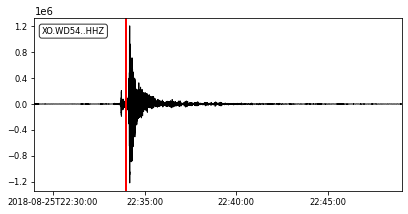

Press Enter to continue... 


WD54
HH2
1 Trace(s) in Stream:
XO.WD54..HH2 | 2018-08-25T22:29:10.082200Z - 2018-08-25T22:49:10.072200Z | 100.0 Hz, 120000 samples


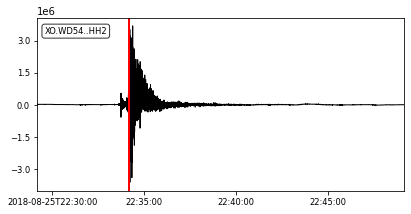

Press Enter to continue... 


LD38
HHZ
1 Trace(s) in Stream:
XO.LD38..HHZ | 2018-08-25T22:29:11.089600Z - 2018-08-25T22:49:11.079600Z | 100.0 Hz, 120000 samples


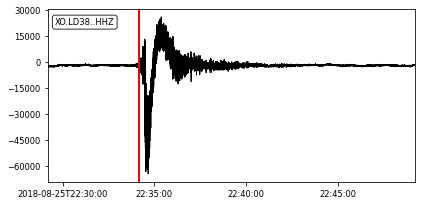

Press Enter to continue... 


WD70
HHZ
1 Trace(s) in Stream:
XO.WD70..HHZ | 2018-08-25T22:29:12.088800Z - 2018-08-25T22:49:12.078800Z | 100.0 Hz, 120000 samples


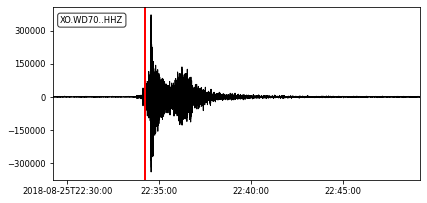

Press Enter to continue... 


WS72
HHZ
1 Trace(s) in Stream:
XO.WS72..HHZ | 2018-08-25T22:29:14.086400Z - 2018-08-25T22:49:14.076400Z | 100.0 Hz, 120000 samples


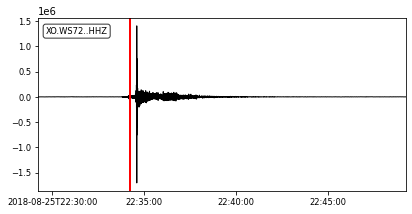

Press Enter to continue... 


LA39
HHZ
1 Trace(s) in Stream:
XO.LA39..HHZ | 2018-08-25T22:29:14.088400Z - 2018-08-25T22:49:14.078400Z | 100.0 Hz, 120000 samples


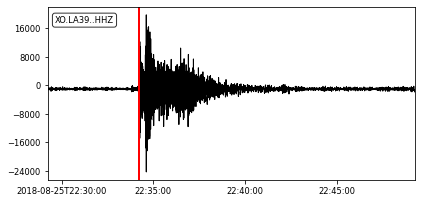

Press Enter to continue... 


LD40
HHZ
1 Trace(s) in Stream:
XO.LD40..HHZ | 2018-08-25T22:29:16.082500Z - 2018-08-25T22:49:16.072500Z | 100.0 Hz, 120000 samples


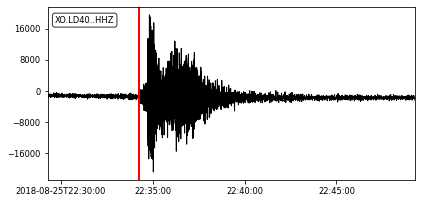

Press Enter to continue... 


WD48
HHZ
1 Trace(s) in Stream:
XO.WD48..HHZ | 2018-08-25T22:29:17.080401Z - 2018-08-25T22:49:17.070401Z | 100.0 Hz, 120000 samples


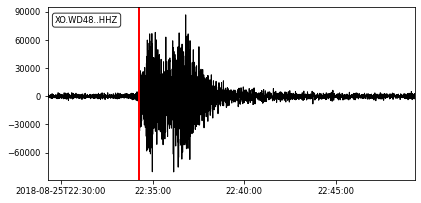

Press Enter to continue... 


WD51
HHZ
1 Trace(s) in Stream:
XO.WD51..HHZ | 2018-08-25T22:29:20.084200Z - 2018-08-25T22:49:20.074200Z | 100.0 Hz, 120000 samples


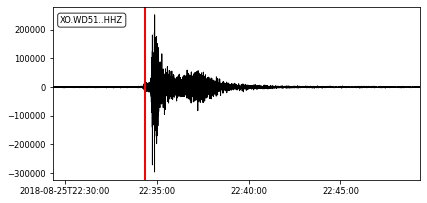

Press Enter to continue... 


LD41
HHZ
1 Trace(s) in Stream:
XO.LD41..HHZ | 2018-08-25T22:29:27.087400Z - 2018-08-25T22:49:27.077400Z | 100.0 Hz, 120000 samples


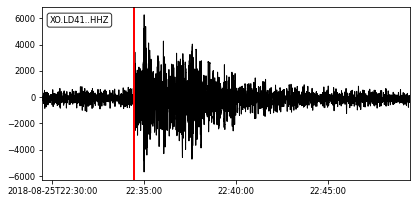

Press Enter to continue... 


LD38
HH1
1 Trace(s) in Stream:
XO.LD38..HH1 | 2018-08-25T22:29:27.089600Z - 2018-08-25T22:49:27.079600Z | 100.0 Hz, 120000 samples


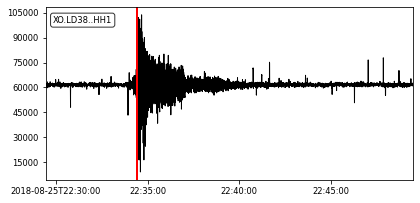

Press Enter to continue... 


KS03
HHZ
1 Trace(s) in Stream:
XO.KS03..HHZ | 2018-08-25T22:29:28.089998Z - 2018-08-25T22:49:28.079998Z | 100.0 Hz, 120000 samples


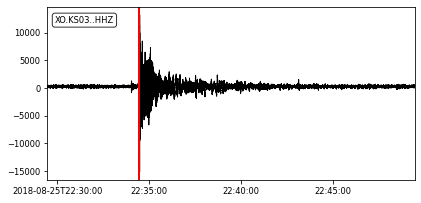

In [ ]:
# Load catalog info for one month
month = '2018_08'
(assoc,arrivals,origin) = read_files(month)

# Sort events by magnitude, descending
origin = origin.sort_values(by=['magnitude'],ascending=False)
origin_ids = origin['originid']

# Loop through events
for id in origin_ids:

    # Get arrivals associated with this earthquake
    subset = assoc.loc[assoc['originid']==id]
    arrival_subset = arrivals.iloc[subset['arrivalid']-1]
    arrival_subset.reset_index(drop=True,inplace=True)
    
    # Get station names
    stations = arrival_subset['stationcode']
    
    # Get list of stations that have more than one pick
    repeats = []
    for element in stations:
        if sum(stations==element) > 1:
            repeats.append(element)
    repeats = np.unique(repeats)

    repeat_subset = arrival_subset.loc[(arrival_subset['stationcode'].isin(repeats)) & (arrival_subset['phase']=='P')]
    repeat_subset = arrival_subset.loc[(arrival_subset['stationcode'].isin(repeats))]
    repeat_subset.reset_index(drop=True,inplace=True)
    print(repeat_subset)

    
    # Loop through picks
    for i in range(0,len(repeat_subset)):
        pick = repeat_subset.iloc[i]
        # P arrival time:
        pick_epoch = pick['epochtime']
        basetime = datetime.datetime.utcfromtimestamp(pick_epoch).strftime('%Y-%m-%dT%H:%M:%S.%m')

        
        # We want the streams for 20 minutes before and after the pick time:
        t1 = UTCDateTime(basetime)-datetime.timedelta(minutes = 5)
        t2 = UTCDateTime(basetime)+datetime.timedelta(minutes = 15)

        # Now we query the data from IRIS for each of the stations 20 min before and after the origin time, and add it to the master stream:
        client = Client("IRIS")
        print(pick['stationcode'])
        print(pick['channel'])
        # Download the streams INCLUDING the instrument response:
        st = client.get_waveforms("XO",pick['stationcode'], "--",pick['channel'], t1, t2,attach_response=True)
        print(st)
        # Plot the raw waveform:
        %matplotlib inline
        fig = plt.figure()
        st.plot(fig = fig)                                      
        plt.axvline(x=basetime,linewidth=2, color='r')
        plt.show()

        input("Press Enter to continue...")